# Modelado v2.0 - Datos del log y resumidos de entregas y notas de las actividades
---

En este notebook , se desarrolla la segunda iteración del modelado, en la cual se explora el funcionamiento de los cuatro modelos probados en la anterior iteración, pero utilizando un dataset nuevo, el cual contiene la misma cantidad de instancias (los 201 estudiantes del curso durante el año 23/24) pero features diferentes. Estas features recopilan información de acceso de los alumnos al curso, y dos columnas asociadas a las actividades de evaluación continua, la proporción de entregas realizadas del total disponibles, y la nota media obtenida en ellas. 

Cabe destacar que la fecha de corte considerada para separar las ventanas ha seguido siendo la misma utilizada para todo el proyecto. 

La principal motivación detras de probar el rendimiento de los modelos sobre este conjunto de datos es ver si pueden ofrecer un rendimiento mejor, dado que son métricas con las cuales podríamos generalizar mejor en un futuro a otras asignaturas, dado que son adaptables para cualquier aula que exigiera una interacción frecuente con el aula virtual y tuviera la misma proporción de alumnos y abandonos. 

In [2]:
# Core
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

# Modelado
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (f1_score, roc_auc_score,
                                           precision_score, recall_score,
                                           make_scorer)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from scikeras.wrappers import KerasClassifier

# Desbalance
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from tensorflow import keras
from tensorflow.keras.optimizers import Adam

import random
import joblib, os
import tensorflow as tf

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
os.environ["PYTHONHASHSEED"] = str(SEED)

#----------Rutas de los datos----------
DATA_PATH = '/home/carlos/Documentos/TFG/spark-workspace/data/datasets/'

# --- Carpeta donde guardaremos los modelos entrenados ---
MODEL_PATH = "models_v2.0"
os.makedirs(MODEL_PATH, exist_ok=True)


## Carga de datos 


In [3]:
df = pd.read_parquet(f"{DATA_PATH}/dataset_2.0.parquet")

# 4. Separar X / y
X = df.drop(columns=["userid", "abandona"])
y = df["abandona"]

display(df.head(3))
print("X shape:", X.shape)
print(X.info())

,userid,nota_media_actividades,proporcion_actividades_hechas,num_accesos,num_accesos_sept,num_accesos_oct,num_accesos_nov,max_dias_sin_acceso,max_dias_consecutivos_accediendo,abandona
0,e1f1d0f48ca77093f9d66cefd325504245277db3e6c145...,8.416667,0.857143,183,63,81,39,5,12,0
1,b5de2bb5b8538b199d6b3f0ecb32daa8a9d730ccc484db...,8.892857,1.000000,149,53,58,38,6,7,0
2,90a634296aff946e9d045997d512d2b77dbc01880715c1...,8.380953,1.000000,102,31,40,31,6,6,1


X shape: (201, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 201 entries, 0 to 200
Data columns (total 8 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nota_media_actividades            201 non-null    float64
 1   proporcion_actividades_hechas     201 non-null    float64
 2   num_accesos                       201 non-null    int64  
 3   num_accesos_sept                  201 non-null    int64  
 4   num_accesos_oct                   201 non-null    int64  
 5   num_accesos_nov                   201 non-null    int64  
 6   max_dias_sin_acceso               201 non-null    int32  
 7   max_dias_consecutivos_accediendo  201 non-null    int64  
dtypes: float64(2), int32(1), int64(5)
memory usage: 11.9 KB
None


## Definir pipeline de los modelos tradicionales

In [4]:
# --- Preprocesador único: escala todas las columnas ---
preprocessor = ColumnTransformer(
      [("scaler", StandardScaler(), X.columns)],
      remainder="passthrough",
)


def make_pipeline(name: str, use_smote: bool):
    """
    Devuelve (pipeline, ruta_a_guardar) según el nombre del modelo y si aplicamos SMOTE.
    Todos usan el mismo 'preprocessor'.
    """
    # Selección de clasificador base
    if name == "LogReg":
        clf = LogisticRegression(class_weight="balanced", max_iter=1000, random_state=SEED)
    elif name == "Tree":
        clf = DecisionTreeClassifier(class_weight="balanced", random_state=SEED)
    elif name == "XGB":
        ratio = (y == 0).sum() / (y == 1).sum()
        clf = XGBClassifier(
            n_estimators=200,
            max_depth=4,
            learning_rate=0.05,
            subsample=0.8,
            colsample_bytree=0.8,
            eval_metric="logloss",
            scale_pos_weight=y.value_counts()[0] / y.value_counts()[1],
            random_state= SEED,
        )
    else:
        raise ValueError(f"Modelo desconocido: {name}")

    # Montamos el pipeline
    steps = [("pre", preprocessor)]
    if use_smote:
        steps.append(("smote", SMOTE()))
    steps.append(("clf", clf))

    pipe = ImbPipeline(steps) if use_smote else Pipeline(steps)

    # Definimos nombre de fichero donde guardarlo
    suffix = "_smote" if use_smote else ""
    fname = os.path.join(MODEL_PATH, f"{name.lower()}{suffix}.pkl")
    return pipe, fname

## Evaluación + guardado de los 3 modelos “tradicionales”

In [7]:
# ============================================================
# 1) Cross‐validation determinista, métricas y guardado de modelos clásicos
# ============================================================
import os
import joblib
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate, StratifiedKFold

# Ya debes haber fijado SEED globalmente al inicio del notebook:
#   SEED = 42
#   import random, numpy as np, tensorflow as tf; random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

scoring = ["f1", "roc_auc", "precision", "recall"]
# Definimos un CV estratificado reproducible
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

def evaluate_and_save(name: str, use_smote: bool = False):
    """
    - Ejecuta CV estratificada reproducible (5 folds) con las métricas de interés.
    - Re-entrena el pipeline con TODO el dataset.
    - Guarda el pipeline en disco.
    - Devuelve un dict con medias ± std de las métricas y la ruta al .pkl.
    """
    # 1) Construir pipeline y archivo
    pipe, fname = make_pipeline(name, use_smote)
    
    # 2) Fijar semillas en los pasos estocásticos
    #    Clasificador
    pipe.named_steps["clf"].set_params(random_state=SEED)
    #    SMOTE (si está presente)
    if use_smote:
        pipe.named_steps["smote"].set_params(random_state=SEED)
    
    # 3) Validación cruzada reproducible
    cvres = cross_validate(
        pipe,
        X, y,
        cv=cv,
        scoring=scoring,
        return_train_score=False
    )
    metrics = {
        m: (cvres[f"test_{m}"].mean(), cvres[f"test_{m}"].std())
        for m in scoring
    }

    # 4) Reentrenamos sobre todo el dataset y guardamos
    pipe.fit(X, y)
    joblib.dump(pipe, fname)

    return {
        "model": f"{name}{'+SMOTE' if use_smote else ''}",
        "file": fname,
        **metrics
    }

# Ejecutamos para LR, Árbol y XGB (con y sin SMOTE)
results = []
for mdl in ["LogReg", "Tree", "XGB"]:
    results.append(evaluate_and_save(mdl, use_smote=False))
    results.append(evaluate_and_save(mdl, use_smote=True))

# Construir DataFrame de métricas reproducible
rows = []
for r in results:
    row = {"model": r["model"]}
    for m in scoring:
        mean, std = r[m]
        row[m] = f"{mean:.3f} ± {std:.3f}"
    rows.append(row)

res_df = pd.DataFrame(rows).set_index("model")
display(res_df)


,f1,roc_auc,precision,recall
model,,,,
LogReg,0.551 ± 0.153,0.802 ± 0.119,0.463 ± 0.133,0.686 ± 0.192
LogReg+SMOTE,0.508 ± 0.161,0.798 ± 0.128,0.429 ± 0.134,0.624 ± 0.206
Tree,0.409 ± 0.075,0.644 ± 0.034,0.456 ± 0.153,0.395 ± 0.076
Tree+SMOTE,0.430 ± 0.085,0.664 ± 0.060,0.427 ± 0.067,0.448 ± 0.140
XGB,0.595 ± 0.139,0.840 ± 0.091,0.604 ± 0.178,0.600 ± 0.097
XGB+SMOTE,0.543 ± 0.148,0.802 ± 0.092,0.470 ± 0.120,0.652 ± 0.206


 ## Cross-validation de la Red Neuronal (solo métricas + curva de AUC por época)


In [8]:
# ============================================================
# CV de la Red Neuronal con/sin SMOTE (5 folds, DataFrame)
# ============================================================
import numpy as np
import pandas as pd

from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_validate
from scikeras.wrappers import KerasClassifier
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE

# --- 1) Construcción del wrapper Keras idéntico al de Modelado.py ----
def build_model(meta, units=64, dr=0.3):
    n_features = meta["n_features_in_"]
    model = Sequential([
        Dense(units, activation="relu", input_shape=(n_features,)),
        Dropout(dr),
        Dense(units // 2, activation="relu"),
        Dense(1, activation="sigmoid")
    ])
    model.compile(
        optimizer=Adam(1e-3),
        loss="binary_crossentropy",
        metrics=["accuracy"]
    )
    return model

ratio = y.value_counts()[0] / y.value_counts()[1]
nn_clf = KerasClassifier(
    model=build_model,
    epochs=60,
    batch_size=16,
    verbose=0,
    fit__class_weight={0: 1, 1: ratio},
    random_state=SEED
)

# --- 2) Pipelines: sin SMOTE y con SMOTE --------------------------
pipe_no = Pipeline([
    ("pre", preprocessor),
    ("nn",  nn_clf)
])
pipe_sm = ImbPipeline([
    ("pre",   preprocessor),
    ("smote", SMOTE()),
    ("nn",    nn_clf)
])

# --- 3) Cross‐validation para ambos ----------------------------------
cv      = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
scoring = ["f1", "roc_auc", "precision", "recall"]

results = {}
for name, pipe in [("NN", pipe_no), ("NN+SMOTE", pipe_sm)]:
    cvres = cross_validate(
        pipe, X, y,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
    )
    # guardar mean/std de cada métrica
    results[name] = {
        m: (cvres[f"test_{m}"].mean(), cvres[f"test_{m}"].std())
        for m in scoring
    }

# --- 4) Montar DataFrame final ---------------------------------------
df = pd.DataFrame({
    name: {metric: f"{mean:.3f} ± {std:.3f}"
           for metric, (mean, std) in mets.items()}
    for name, mets in results.items()
})

# --- 5) Mostrar resultados ------------------------------------------
print("Neural Network – 5-fold CV (métricas mean ± std)")
display(df)


2025-06-22 12:00:06.846085: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-22 12:00:06.848349: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-22 12:00:06.853053: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-22 12:00:06.860461: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750586406.878524   11983 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750586406.88

Neural Network – 5-fold CV (métricas mean ± std)


,NN,NN+SMOTE
f1,0.477 ± 0.201,0.423 ± 0.155
roc_auc,0.778 ± 0.147,0.775 ± 0.154
precision,0.392 ± 0.170,0.310 ± 0.117
recall,0.619 ± 0.256,0.681 ± 0.240


## Visualizaciones de LR


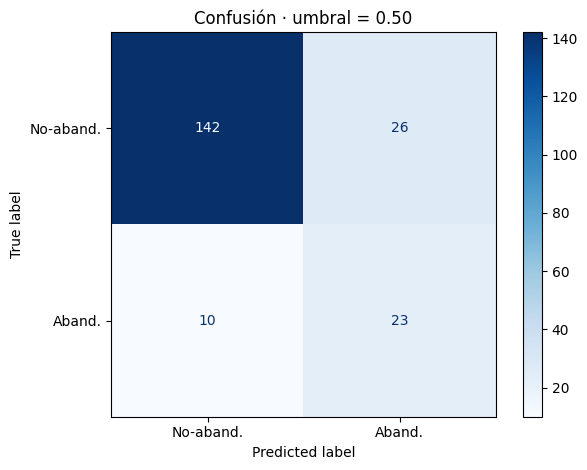

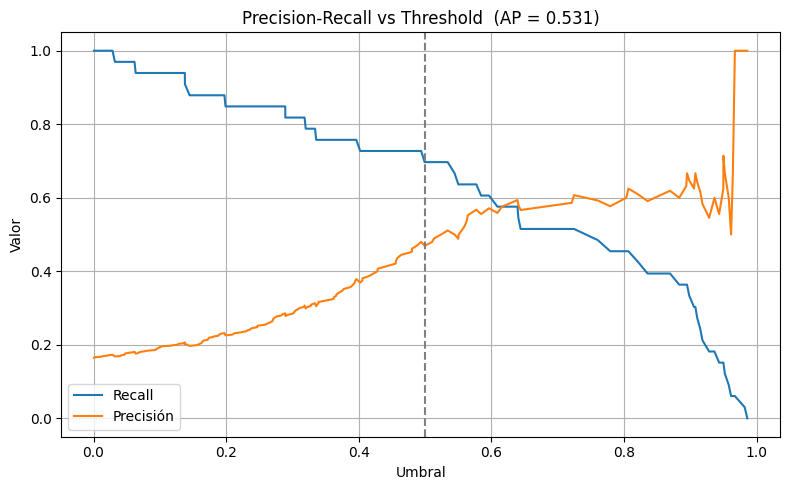

,feature,coef,abs_coef
0,scaler__num_accesos_nov,-1.534899,1.534899
1,scaler__proporcion_actividades_hechas,-0.902383,0.902383
2,scaler__num_accesos_oct,0.870326,0.870326
3,scaler__max_dias_consecutivos_accediendo,-0.211148,0.211148
4,scaler__num_accesos,-0.164064,0.164064
5,scaler__max_dias_sin_acceso,-0.140923,0.140923
6,scaler__num_accesos_sept,-0.034572,0.034572
7,scaler__nota_media_actividades,-0.010793,0.010793


In [9]:
# Visualizar coeficientes de la regresión logística,
# Curva PR con umbrales y matriz de confusión

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    precision_recall_curve, average_precision_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# %%  PIPELINE BASE  (usa la función make_pipeline definida antes) ─────────────
pipe_base, _ = make_pipeline(
    name="LogReg",
    use_smote=False
)
# Forzamos determinismo en los dos puntos sensibles:
pipe_base.named_steps["clf"].set_params(random_state=SEED)  # LogisticRegression
# (SMOTE no se usa aquí; si lo habilitas → .set_params(random_state=SEED))

# %%  PREDICCIONES CV  (fuera-de-muestra) ──────────────────────────────────────
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

y_scores = cross_val_predict(
    pipe_base, X, y,
    cv=cv, method="predict_proba",
    n_jobs=-1
)[:, 1]

thr = 0.50
y_pred = (y_scores >= thr).astype(int)

# %%  MATRIZ DE CONFUSIÓN  ─────────────────────────────────────────────────────
cm = confusion_matrix(y, y_pred, labels=[0, 1])
ConfusionMatrixDisplay(cm, display_labels=["No-aband.", "Aband."]) \
    .plot(cmap=plt.cm.Blues)
plt.title(f"Confusión · umbral = {thr:.2f}")
plt.tight_layout(); plt.show()

# %%  CURVA P-R  ───────────────────────────────────────────────────────────────
prec, rec, ths = precision_recall_curve(y, y_scores)
ap = average_precision_score(y, y_scores)

plt.figure(figsize=(8, 5))
plt.plot(ths, rec[1:], label="Recall")
plt.plot(ths, prec[1:], label="Precisión")
plt.axvline(thr, ls="--", color="grey")
plt.xlabel("Umbral"); plt.ylabel("Valor")
plt.title(f"Precision-Recall vs Threshold  (AP = {ap:.3f})")
plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

# %%  ENTRENAR MODELO FINAL PARA COEFICIENTES  ────────────────────────────────
pipe_final, _ = make_pipeline("LogReg", use_smote=False)
pipe_final.named_steps["clf"].set_params(random_state=SEED)
pipe_final.fit(X, y)

feat_names = pipe_final.named_steps["pre"].get_feature_names_out()
coef       = pipe_final.named_steps["clf"].coef_[0]

coef_df = (pd.DataFrame({"feature": feat_names, "coef": coef})
             .assign(abs_coef=lambda d: d.coef.abs())
             .sort_values("abs_coef", ascending=False)
             .reset_index(drop=True))

display(coef_df.head(20))   # Top-20 características


# Probar métricas con umbral 0.60



Métricas (threshold = 0.60):
  • F1-score : 0.588
  • Precision: 0.571
  • Recall   : 0.606
  • ROC AUC  : 0.805


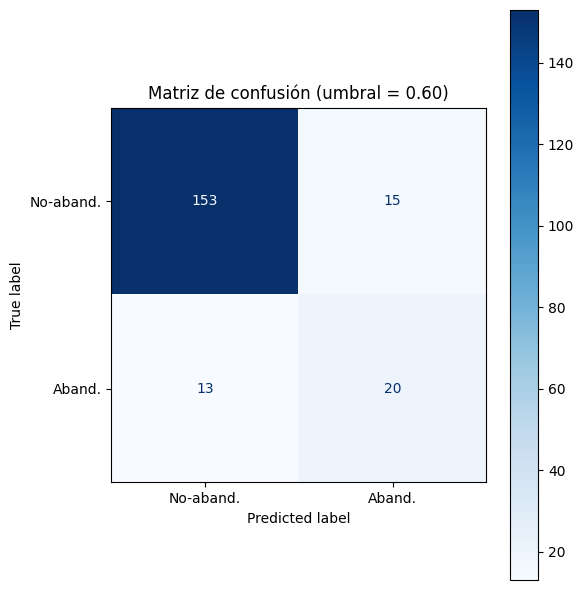

In [17]:

# - Predicciones fuera-de-muestra con `cross_val_predict` (5-fold Stratified CV con semilla fija)  
# - Cálculo de métricas reales para un umbral dado  
# - Matriz de confusión sobre esas predicciones

# %%
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, ConfusionMatrixDisplay
)

# --- 1) Pipeline base y CV determinista ---------------------------------------
# Reutiliza make_pipeline; no SMOTE para evaluación
pipe_base, _ = make_pipeline("LogReg", use_smote=False)
# Asegura semilla en el clasificador
pipe_base.named_steps["clf"].set_params(random_state=SEED)

# CV estratificado reproducible
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# --- 2) Predicciones probabilísticas fuera-de-muestra -------------------------
y_prob = cross_val_predict(
    pipe_base, X, y,
    cv=cv,
    method="predict_proba",
    n_jobs=-1
)[:, 1]

# --- 3) Umbral y predicciones discretas ----------------------------------------
threshold = 0.6
y_pred_thr = (y_prob >= threshold).astype(int)

# --- 4) Cálculo de métricas ---------------------------------------------------
f1        = f1_score(y, y_pred_thr)
precision = precision_score(y, y_pred_thr)
recall    = recall_score(y, y_pred_thr)
roc_auc   = roc_auc_score(y, y_prob)

print(f"Métricas (threshold = {threshold:.2f}):")
print(f"  • F1-score : {f1:.3f}")
print(f"  • Precision: {precision:.3f}")
print(f"  • Recall   : {recall:.3f}")
print(f"  • ROC AUC  : {roc_auc:.3f}")

# --- 5) Matriz de confusión ---------------------------------------------------
cm = confusion_matrix(y, y_pred_thr, labels=[0, 1])
disp = ConfusionMatrixDisplay(cm, display_labels=["No-aband.", "Aband."])
fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(ax=ax, cmap=plt.cm.Blues)
ax.set_title(f"Matriz de confusión (umbral = {threshold:.2f})")
plt.tight_layout()
plt.show()
